# Importing Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-04 12:23:55.102317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 12:23:55.102448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 12:23:55.259988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = "/kaggle/input/snakeclef-2022-reordered/SnakeCLEF2022-small_size/"

In [3]:
image_size = 256
batch_size = 32
channels = 3

In [4]:
tf.__version__

'2.15.0'

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    
    shuffle=True,
    seed=69,
    
    image_size = (image_size,image_size),
    batch_size = 32
)

Found 270249 files belonging to 1572 classes.


# Data Viz

In [6]:
class_names = dataset.class_names
for i in range(10):
    print(class_names[i])

Acanthophis_antarcticus
Acanthophis_laevis
Acanthophis_praelongus
Acanthophis_pyrrhus
Acanthophis_rugosus
Acanthophis_wellsi
Achalinus_formosanus
Achalinus_niger
Achalinus_rufescens
Achalinus_spinalis


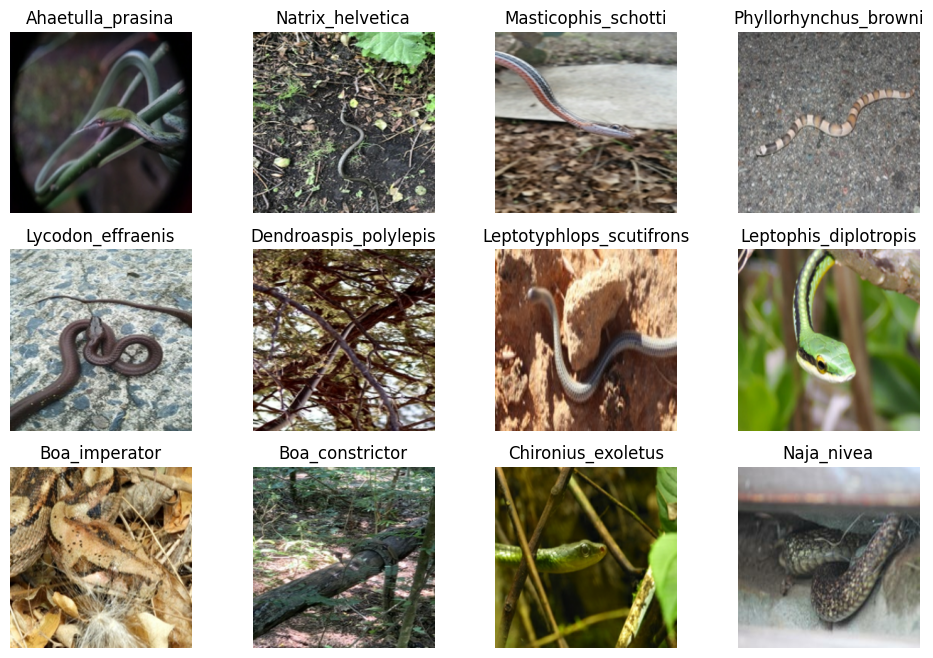

In [7]:
plt.figure(figsize=(12, 8))

for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        
        plt.axis("off")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
#         print(labels_batch[i])
        
        plt.title(
            class_names[
                np.array([labels_batch[i]])[0]
            ]
        
        )
        

In [8]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Dataset Splitting

In [9]:
len(dataset) # Number of batches

8446

In [10]:
def train_val_test_split_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=69)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds